# INM705 Coursework
### Aaron Mir (Student Number: 160001207) and Sarah Rhalem (Student Number: 190051884)

This is from the INM701 coursework guidelines but I am keeping it here because it has some good points in it.

In this coursework, you are expected to demonstrate what you have learned in the module by applying techniques as covered in the module to a dataset and domain of your choice. This will include some or all of:

    • Define the domain and dataset(s) (you are free to choose the domain and the dataset that you want to investigate).

    • Define  questions and analysis tasks (a brief overview  of  the  domain, analytical questions that are being asked, a list of your objectives and the 
    expected output(s)of your analysis)
    
    • Perform an initial investigation of the dataset and the characteristics of the data. Develop a viable plan: which data processing steps you will need to
    perform, how you will transform the data to make it useable, which artificial intelligence techniques you can potentially use and what sorts of potential
    observations these can lead to.

    • Perform the analysis.  Get the data ready for analysis, carry out your analysis/modelling as needed, validate your results and communicate observations, 
    iterating through this process. Analytical operations can include data processing to an extent that is needed (not all datasets are messy) to prepare a useful and
    robust dataset to work within, and data derivation (such as feature engineering).

    • Split your dataset (train/validate/test, somedatasets come pre-split). If you have a holdout test set then you most likely don’t want to use this until the near 
    the end of your work.

    • You might establish a baseline result first, computing metrics on training and validation sets,  analyse  errors, work  on  succeeding iterations, and 
    alternative models. (If initial metrics are amazing and there are no errors is the problem too easy?)

    • Be  close to your data  (visualise  the  dataset,  collect  summary  statistics,  look  at  errors, analyse how different parameters affect performance, try 
    out different model variants).


## Semantic Segmentation of Brain Tumours using U-Net and Fully Convolutional Network

In [3]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch 
import torchvision
import nibabel as nib
from nibabel.testing import data_path
from PIL import Image

In [4]:
##--------------------Coding References---------------------##
# Percentage of borrowed code: X% - 
# [1] 

In [5]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")

Python: 3.8.7 (tags/v3.8.7:6503f05, Dec 21 2020, 17:59:51) [MSC v.1928 64 bit (AMD64)]
Numpy Version: 1.19.5
PyTorch Version: 1.7.1+cu110


## Data Preprocessing

## Investigating the first training image

In [21]:
image_1 = os.path.join('data\\train\\BRATS_001.nii.gz') # accessing the first training image

In [22]:
image_1 = nib.load(image_1) # loading the training image

In [23]:
image_1.shape # looking at the shape (240x240 pixels), 155 frames, 4 dimensions (FLAIR, T1w, T1gd, T2w)

(240, 240, 155, 4)

In [24]:
print(image_1) # looking at the header

<class 'nibabel.nifti1.Nifti1Image'>
data shape (240, 240, 155, 4)
affine: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 240 240 155   4   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quater

In [25]:
image_1_data = image_1.get_data()

In [26]:
image_1_data_arr = np.asarray(image_1_data) # transforming to np array

In [27]:
image_1_data_arr.shape # looking at the shape

(240, 240, 155, 4)

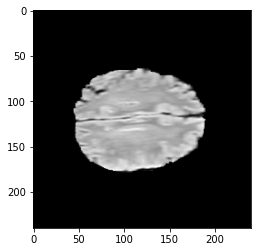

In [40]:
plt.imshow(image_1_data_arr[:,:,106,0], cmap='gray'); # plotting the FLAIR (0th dimension) of the 106th frame of the 1st training image

## Investigating the label for the first training image

In [32]:
image_1_label = os.path.join('data\\train_labels\\BRATS_001.nii.gz') # accessing the label for the first training image

In [33]:
image_1_label = nib.load(image_1_label) # loading the label for the first training image

In [34]:
image_1_label.shape # investigating the shape (240x240 pixels), 155 frames each frame represents the pixels where the tumour is present as demonstrated below 

(240, 240, 155)

In [9]:
print(image_1_label) # looking at the header for the label

<class 'nibabel.nifti1.Nifti1Image'>
data shape (240, 240, 155)
affine: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c   

In [35]:
image_1_label_data = image_1_label.get_data()

In [36]:
image_1_label_data_arr = np.asarray(image_1_label_data) # converting to np array

In [37]:
image_1_label_data_arr.shape # investigating the shape

(240, 240, 155)

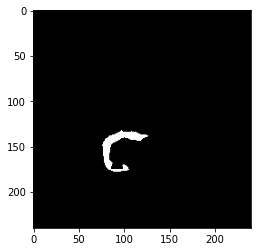

In [39]:
plt.imshow(image_1_label_data_arr[:,:,95], cmap='gray'); # plotting the label of the 1st training image - 95th frame shows clearly the tumour

In [ ]:
#img = Image.fromarray(img_data_arr[:,:,15,0], 'L')
#img.save("image.jpeg")

## U-Net

## Evaluation of U-Net

## Fully Convolutional Network

## Evaluation of Fully Convolutional Network
